In [2]:
import os
import torch
import torch.nn as nn
import torchvision.transforms as T
import numpy as np
import cv2
import pandas as pd
from PIL import Image
from scipy import ndimage
import torchvision
import torch
from torchvision import models
from skimage.measure import label, regionprops

In [3]:
import matplotlib.pyplot as plt

def overlay_masks_on_image(image, masks_with_sizes, alpha=0.4):
    """
    image: HxWx3 numpy array (RGB)
    masks_with_sizes: list of (mask, size)
    alpha: transparency for mask overlays
    """
    overlay = image.copy()

    # Define distinct colors for up to 3 masks (BGR order for cv2)
    colors = [
        (255, 0, 0),    # Blue
        (0, 255, 0),    # Green
        (0, 0, 255),    # Red
    ]

    for i, (mask, _) in enumerate(masks_with_sizes):
        color = colors[i % len(colors)]
        # Create color layer
        colored_mask = np.zeros_like(overlay, dtype=np.uint8)
        for c in range(3):
            colored_mask[:, :, c] = mask * color[c]

        # Blend colored mask with the overlay image
        overlay = cv2.addWeighted(overlay, 1.0, colored_mask, alpha, 0)

        # Optionally: draw contours for better separation
        contours, _ = cv2.findContours(mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cv2.drawContours(overlay, contours, -1, color, 2)

    return overlay


/opt/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Enter root folder path containing image subfolders:  Open_eyes_dataset_flat_test
Enter image filename (with extension):  2022-10-17 11:18:10.759307-1977.jpg


Results for image: 2022-10-17 11:18:10.759307-1977.jpg

Mask1 (Score: 53367 pixels):
  Eccentricity: 0.955
  Has two non-overlapping regions: True

Mask2 (Score: 0 pixels):
  Eccentricity: 0.000
  Has two non-overlapping regions: False

Mask3 (Score: 0 pixels):
  Eccentricity: 0.000
  Has two non-overlapping regions: False



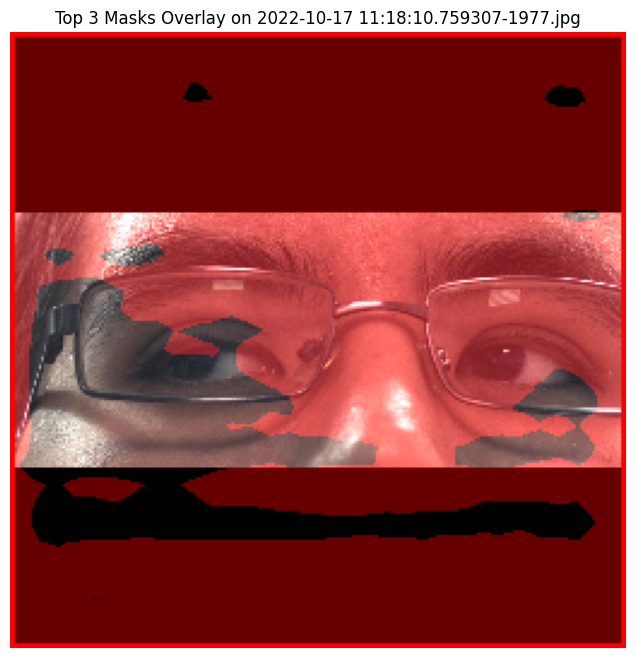

In [6]:
def generate_point_map(image_shape, points):
    """Create a single-channel point map with 1s at given points"""
    h, w = image_shape
    point_map = np.zeros((h, w), dtype=np.float32)
    for (x, y) in points:
        if 0 <= y < h and 0 <= x < w:
            point_map[y, x] = 1.0
    return point_map

def has_two_non_overlapping_regions(mask):
    labeled = label(mask)
    regions = regionprops(labeled)
    if len(regions) < 2:
        return False
    # Check if any two regions do not overlap (they won't since labeled regions are distinct)
    # So just return True if 2+ regions exist
    return True

def calculate_eccentricity(mask):
    labeled = label(mask)
    regions = regionprops(labeled)
    if not regions:
        return 0
    # Return max eccentricity of all regions
    return max(region.eccentricity for region in regions)

def select_top_masks(masks, top_k=3):
    """Select top_k masks by size descending"""
    sizes = [np.sum(m) for m in masks]
    sorted_indices = np.argsort(sizes)[::-1][:top_k]
    return [(masks[i], sizes[i]) for i in sorted_indices]

def resize_with_aspect_ratio(image, max_size=256):
    h, w = image.shape[:2]
    scale = max_size / max(h, w)
    new_w, new_h = int(w * scale), int(h * scale)
    resized = cv2.resize(image, (new_w, new_h))
    return resized, scale


class DeepLabV3Plus_MultiInput(torch.nn.Module):
    def __init__(self, num_classes=1):
        super().__init__()
        self.backbone = models.segmentation.deeplabv3_resnet50(pretrained=True)
        old_conv = self.backbone.backbone.conv1
        self.backbone.backbone.conv1 = torch.nn.Conv2d(
            4, 64, kernel_size=7, stride=2, padding=3, bias=False)
        # Initialize new conv weights for the 4th channel as zeros
        with torch.no_grad():
            self.backbone.backbone.conv1.weight[:, :3, :, :] = old_conv.weight
            self.backbone.backbone.conv1.weight[:, 3:4, :, :] = 0
        # Replace classifier head for single class output
        self.backbone.classifier[-1] = torch.nn.Conv2d(256, num_classes, kernel_size=1)

    def forward(self, x):
        return self.backbone(x)["out"]


def process_single_image(root_folder, image_name, csv_path, model, device):
    # Load CSV once
    coord_df = pd.read_csv(csv_path)
    # Find rows matching just the image name (ignore folder path in CSV if any)
    rows = coord_df[coord_df['actual_filename'] == image_name]
    if rows.empty:
        print(f"ERROR: No coordinate entry found in CSV for image: {image_name}")
        return

    # We expect one row per image name
    row = rows.iloc[0]
    lx, ly = int(row['abs_lx']), int(row['abs_ly'])
    rx, ry = int(row['abs_rx']), int(row['abs_ry'])

    # Search through all subfolders under root_folder to find the image
    img_path = None
    for subfolder in os.listdir(root_folder):
        subfolder_path = os.path.join(root_folder, subfolder)
        if not os.path.isdir(subfolder_path):
            continue
        candidate_path = os.path.join(subfolder_path, image_name)
        if os.path.isfile(candidate_path):
            img_path = candidate_path
            break

    if img_path is None:
        print(f"ERROR: Image {image_name} not found under any subfolder in {root_folder}")
        return

    # Read image in BGR, convert to RGB
    image_bgr = cv2.imread(img_path)
    if image_bgr is None:
        print(f"ERROR: Failed to read image at {img_path}")
        return
    image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

    # Resize image and adjust points accordingly
    image_rgb_resized, scale = resize_with_aspect_ratio(image_rgb, max_size=256)
    lx_scaled, ly_scaled = int(lx * scale), int(ly * scale)
    rx_scaled, ry_scaled = int(rx * scale), int(ry * scale)

    # Create point map (single channel) with two points (left and right eye centers)
    point_map = generate_point_map(image_rgb_resized.shape[:2], [(lx_scaled, ly_scaled), (rx_scaled, ry_scaled)])
    point_map_tensor = torch.from_numpy(point_map).unsqueeze(0)  # 1xHxW

    # Convert image to tensor
    image_tensor = torch.from_numpy(image_rgb_resized.transpose(2, 0, 1)).float() / 255.0  # 3xHxW

    # Combine RGB + point map into 4 channels
    input_tensor = torch.cat([image_tensor, point_map_tensor], dim=0).unsqueeze(0).to(device)  # 1x4xHxW

    model.eval()
    with torch.no_grad():
        output = model(input_tensor)  # 1x1xHxW
        output_mask = torch.sigmoid(output).cpu().numpy()[0, 0]

    # Threshold masks with multiple thresholds for candidate masks
    thresholds = [0.5, 0.6, 0.7, 0.8]
    candidate_masks = [(output_mask > thr).astype(np.uint8) for thr in thresholds]

    # Select top 3 masks by size
    top_masks_with_sizes = select_top_masks(candidate_masks, top_k=3)

    print(f"Results for image: {image_name}\n")
    for idx, (mask, size) in enumerate(top_masks_with_sizes, 1):
        ecc = calculate_eccentricity(mask)
        has_two = has_two_non_overlapping_regions(mask)
        print(f"Mask{idx} (Score: {size} pixels):")
        print(f"  Eccentricity: {ecc:.3f}")
        print(f"  Has two non-overlapping regions: {has_two}\n")

    # Visualize top masks overlayed on image
    overlay_img = overlay_masks_on_image(image_rgb_resized, top_masks_with_sizes, alpha=0.4)

    plt.figure(figsize=(8, 8))
    plt.imshow(overlay_img)
    plt.title(f"Top 3 Masks Overlay on {image_name}")
    plt.axis('off')
    plt.show()
# ==== Usage example ====

if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = DeepLabV3Plus_MultiInput().to(device)

    root_folder = input("Enter root folder path containing image subfolders: ").strip()
    image_name = input("Enter image filename (with extension): ").strip()
    csv_path = "consolidated_coordinates.csv"  # Adjust path if needed

    process_single_image(root_folder, image_name, csv_path, model, device)